In [1]:
import feather
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import chi2
import collections
import re

In [2]:
plt.rcParams["font.family"] = 'Helvetica'
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['pdf.use14corefonts'] = True

savedir = '/casa/jenny/notebooks/pan-viral_MPRA/paper_figures/'

In [3]:
%cd /casa/jenny/basic/pan-viral/220407-AICHI_GStail/level1-RTA/align-optimize/
%ls *

/casa/jenny/basic/pan-viral/220407-AICHI_GStail/level1-RTA/align-optimize
RG7834_id.txt  RO0321_id.txt  WT_id.txt  ZC2KO_id.txt
RG7834.sam     RO0321.sam     WT.sam     ZC2KO.sam


In [4]:
dfs = {}

for s in ['RO0321','RG7834','WT','ZC2KO']:
    tmp = pd.read_csv('%s_id.txt'%s,names=['A'])
    tmp['pA'] = tmp['A'].apply(lambda x: int(x.split(':')[4]))
    tmp['tag'] = tmp['A'].apply(lambda x: x.split(':')[5])
    dfs[s] = tmp

findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


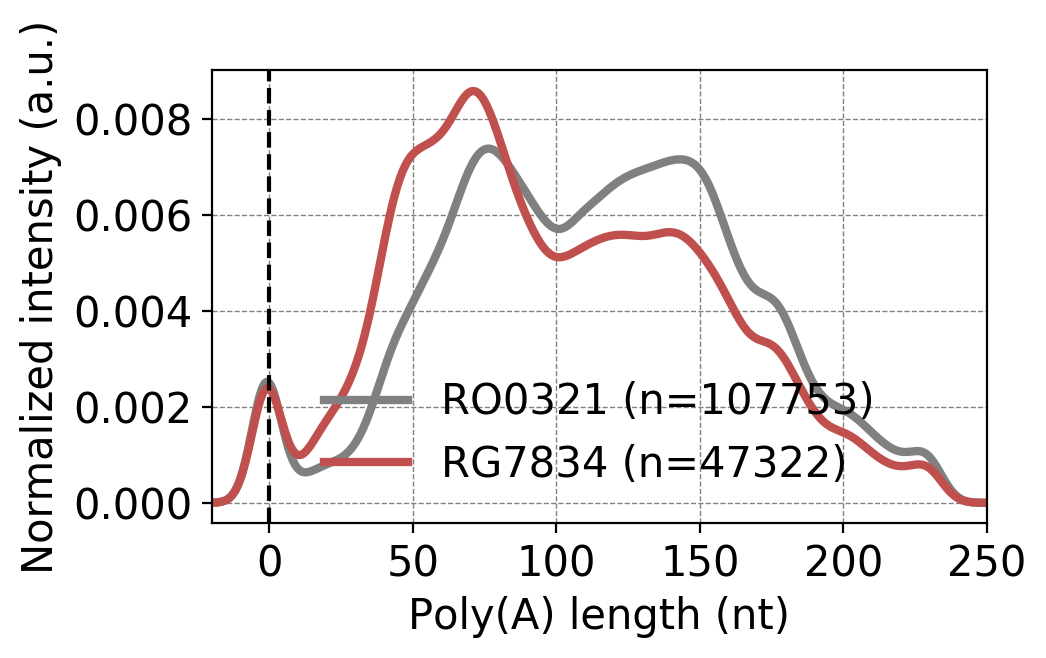

In [7]:
fig,ax = plt.subplots(1,1,figsize=(5,3),dpi=200)
fig.set_facecolor('white')

colors = ["grey","#C0504D"]
for i,s in enumerate(['RO0321','RG7834']):
    dfs[s].pA.plot.kde(bw_method=0.1,label = '%s (n=%s)'%(s,len(dfs[s])),lw=3,ax=ax, color = colors[i])
#     dfs[s].pA.plot.kde(bw_method=0.1,label = '%s'%(s),lw=3,ax=ax, color = colors[i])

ax.set_xlabel("Poly(A) length (nt)",fontsize = 15)
ax.set_ylabel("Normalized intensity (a.u.)",fontsize =15)
ax.set_xlim(-20,250)
ax.set_xticks(np.arange(0,290,50))
ax.axvline(0,color='k',lw=1.5,linestyle='--')
# ax.grid(linestyle='--',lw=1,color='grey')

ax.legend(loc="best", fontsize='x-large',prop={'size': 15},frameon=False)
ax.tick_params (axis = 'x', labelsize =15)
ax.tick_params (axis = 'y', labelsize =15)
ax.grid(linestyle='--',lw=0.5,color='grey')
# ax.set_title('IH', fontsize = 15)

fig.savefig(savedir+'Figure4G(Tailseq,Tail).pdf', format='pdf', transparent=True, bbox_inches='tight')

In [123]:
import sys
sys.path.append('/casa/jenny/software/tailseeker-3.1.7-bundle-ubuntu_xenial/')
from tailseeker.stats import smooth
from tailseeker.plotutils import colormap_lch

In [3]:
%cd /casa/jenny/basic/pan-viral/220309-AICHI_GStail/level3
%ls

/casa/jenny/basic/pan-viral/220309-AICHI_GStail/level3
alignments/    fastq-filtered/   scratch/    taginfo/
associations/  qcplots/          stats/      tailseeker.yaml
fastq/         refined-taginfo/  tagcounts/


In [4]:
import gzip
def get_annotated_taginfo(sample):
    taginfo = pd.read_table(gzip.open('/casa/jenny/basic/pan-viral/220407-AICHI_GStail/level3/refined-taginfo/{}.mapped.txt.gz'.format(sample),'rt'),
                           names = ['tile','cluster','pflags','clones','polyA',\
                                      'unalined_polyA','mods','unaligned_mods'])
    association = pd.read_table(gzip.open('/casa/jenny/basic/pan-viral/220407-AICHI_GStail/level3/associations/{}.txt.gz'.format(sample),'rt'),\
                               names = ['tile','cluster','gene','ambig'])
    
    merged = pd.merge(taginfo,association,left_on=['tile','cluster'],
                      right_on=['tile','cluster'],how='right')
    return merged

# mixed-tail by position

80286
[]
{1: 2053, 2: 2625, 3: 280, 4: 240, 5: 96, 6: 36, 7: 35, 8: 16, 9: 17, 10: 12, 11: 7, 12: 11, 13: 3, 14: 3, 15: 5, 16: 10, 17: 5, 18: 2, 19: 4, 20: 0}
{1: 4988, 2: 5775, 3: 919, 4: 545, 5: 325, 6: 193, 7: 124, 8: 80, 9: 77, 10: 53, 11: 60, 12: 55, 13: 57, 14: 43, 15: 24, 16: 29, 17: 17, 18: 15, 19: 14, 20: 0}


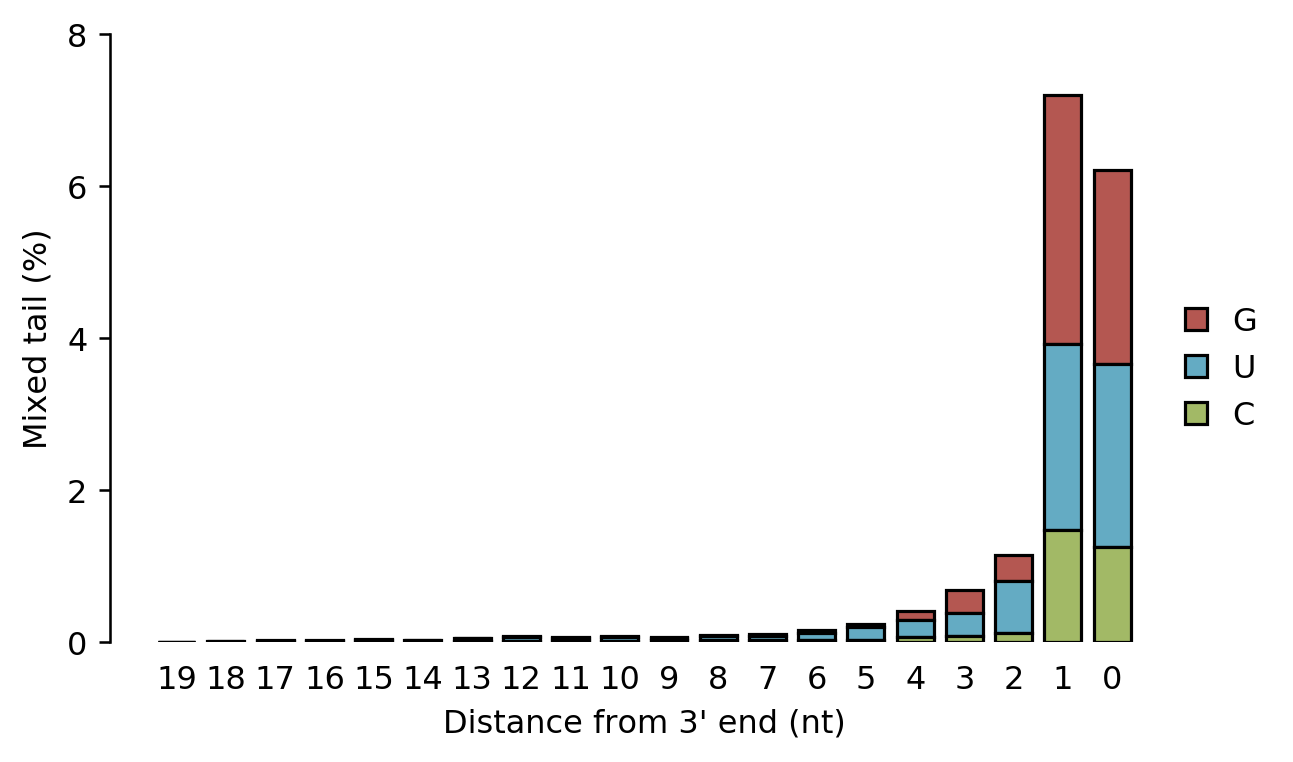

In [33]:
LENCUT = 75
s = 'RO0321'

G = {1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0, 10:0, 11:0, 12:0, 13:0, 14:0, 15:0, 16:0, 17:0, 18:0, 19:0, 20:0}
C = {1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0, 10:0, 11:0, 12:0, 13:0, 14:0, 15:0, 16:0, 17:0, 18:0, 19:0, 20:0}
U = {1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0, 10:0, 11:0, 12:0, 13:0, 14:0, 15:0, 16:0, 17:0, 18:0, 19:0, 20:0}
tot = {1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0, 10:0, 11:0, 12:0, 13:0, 14:0, 15:0, 16:0, 17:0, 18:0, 19:0, 20:0}
comp = []
others = []


for tag in dfs[s][dfs[s]['pA']>LENCUT]['tag']:
    if len(tag)>20:
        comp.append(tag)
    else:
        for i in range(len(tag)):
            if tag[-(i+1)] =='G':
                G[i+1]=G[i+1]+1 ; tot[i+1]=tot[i+1]+1
            elif tag[-(i+1)] =='C':
                C[i+1]=C[i+1]+1 ; tot[i+1]=tot[i+1]+1
            elif tag[-(i+1)] =='T':
                U[i+1]=U[i+1]+1 ; tot[i+1]=tot[i+1]+1

total = len(dfs[s][dfs[s]['pA']>LENCUT])
print(total)
# print(len(G),len(C),len(U),len(others),len(comp))
# print('%.2f'%(len(G)/total*100),'%.2f'%(len(C)/total*100),'%.2f'%(len(U)/total*100))

# print(collections.Counter(G))
# print(collections.Counter(C))
# print(collections.Counter(U))
# print(collections.Counter(others))
print(comp)

print(G)
print(tot)

plt.rcParams["font.family"] = 'Helvetica'
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['pdf.use14corefonts'] = True
fig,ax = plt.subplots(1,1,figsize=(6,3.5),dpi = 230)
fig.set_facecolor('white')


ax.bar([-j for j in range(20)],list(G.values()),
       bottom=[c+u for c,u in zip(C.values(), U.values())],width=0.75,
       align='center',color='#B45751',label='G',zorder=2,edgecolor='k')
ax.bar([-j for j in range(20)],list(U.values()),
       bottom=list(C.values()), width=0.75,align='center',
       label='U',color='#64ABC3',zorder=2,edgecolor='k')
ax.bar([-j for j in range(20)],list(C.values()),width=0.75,align='center',
       label='C',color='#A2B966',zorder=2,edgecolor='k')
        

ax.set_ylim(0,total*0.08)
ax.set_yticks([total*0.02*j for j in range(5)])
ax.set_yticklabels([2*j for j in range(5)])
# ax.set_xlim(-3,1)
ax.set_xticks([-j for j in range(20)])
ax.set_xticklabels([j for j in range(20)],fontsize=10)
# ax.set_xticklabels(sample_list[2:],fontsize=10,ha="right", rotation=55)
# # ax.grid(axis='y',linestyle='--',alpha=0.2,color='k',zorder=1)
# ax.yaxis.grid(True, color='gray',linestyle='-' , linewidth=0.3,alpha=0.7,zorder = 0)

# for i,var in enumerate([3.5]):
#     ax.plot((var,var),(0,14),color='white',linestyle='-', linewidth=2,zorder = 2)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.xaxis.set_ticks_position('none') 

ax.set_ylabel('Mixed tail (%)')
ax.set_xlabel('Distance from 3\' end (nt)')
# plt.title('%s,cut %s'%(s,LENCUT))
ax.legend(frameon=False,  bbox_to_anchor=(1.1, 0.6), handlelength=0.7)
# fig.tight_layout()
fig.savefig(savedir+'Figure_nonAbyPos(%s).pdf'%s,bbox_inches='tight')
plt.show()

38893
[]
{1: 405, 2: 544, 3: 36, 4: 49, 5: 18, 6: 9, 7: 3, 8: 9, 9: 4, 10: 0, 11: 1, 12: 5, 13: 0, 14: 1, 15: 1, 16: 0, 17: 1, 18: 1, 19: 1, 20: 0}
{1: 1071, 2: 1201, 3: 139, 4: 99, 5: 79, 6: 45, 7: 22, 8: 30, 9: 29, 10: 15, 11: 20, 12: 20, 13: 14, 14: 11, 15: 5, 16: 1, 17: 8, 18: 6, 19: 8, 20: 0}


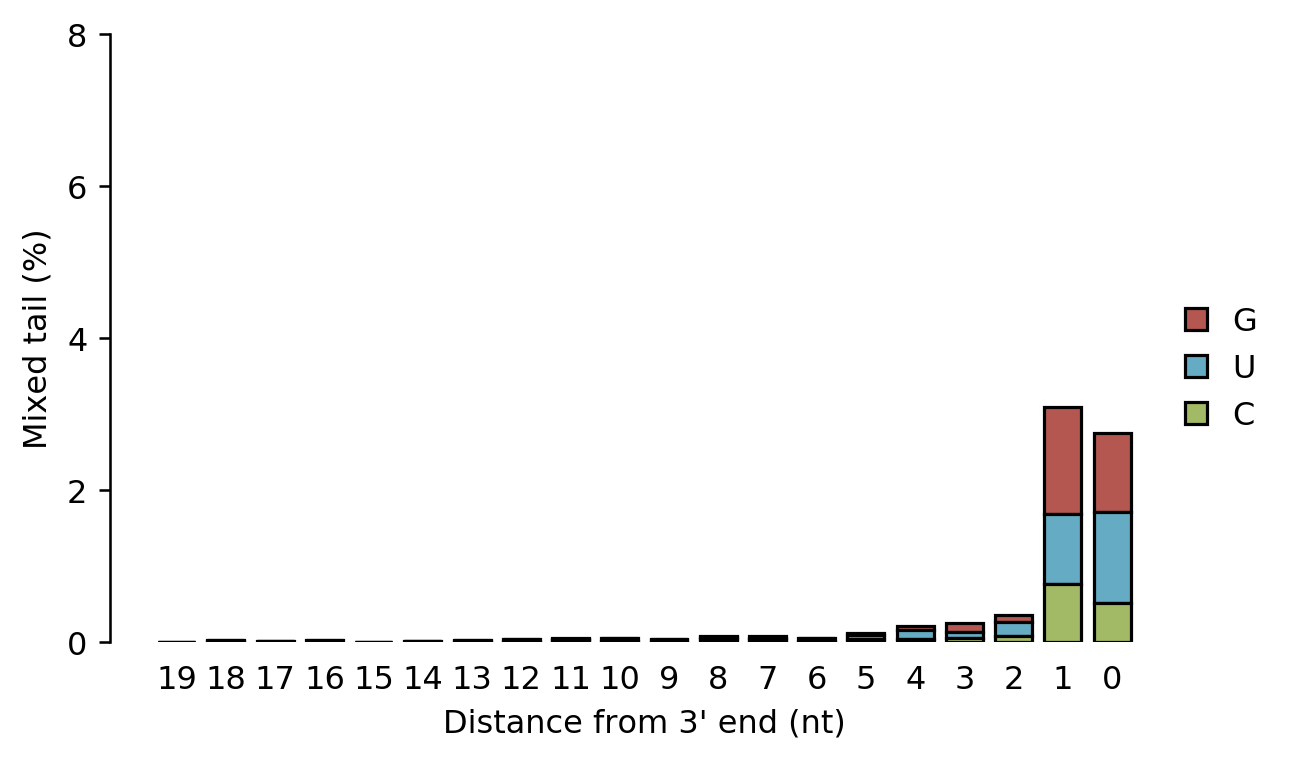

In [35]:
s = 'RG7834'
LENCUT = 50
G = {1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0, 10:0, 11:0, 12:0, 13:0, 14:0, 15:0, 16:0, 17:0, 18:0, 19:0, 20:0}
C = {1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0, 10:0, 11:0, 12:0, 13:0, 14:0, 15:0, 16:0, 17:0, 18:0, 19:0, 20:0}
U = {1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0, 10:0, 11:0, 12:0, 13:0, 14:0, 15:0, 16:0, 17:0, 18:0, 19:0, 20:0}
tot = {1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0, 10:0, 11:0, 12:0, 13:0, 14:0, 15:0, 16:0, 17:0, 18:0, 19:0, 20:0}
comp = []
others = []


for tag in dfs[s][dfs[s]['pA']>LENCUT]['tag']:
    if len(tag)>20:
        comp.append(tag)
    else:
        for i in range(len(tag)):
            if tag[-(i+1)] =='G':
                G[i+1]=G[i+1]+1 ; tot[i+1]=tot[i+1]+1
            elif tag[-(i+1)] =='C':
                C[i+1]=C[i+1]+1 ; tot[i+1]=tot[i+1]+1
            elif tag[-(i+1)] =='T':
                U[i+1]=U[i+1]+1 ; tot[i+1]=tot[i+1]+1

total = len(dfs[s][dfs[s]['pA']>LENCUT])
print(total)
# print(len(G),len(C),len(U),len(others),len(comp))
# print('%.2f'%(len(G)/total*100),'%.2f'%(len(C)/total*100),'%.2f'%(len(U)/total*100))

# print(collections.Counter(G))
# print(collections.Counter(C))
# print(collections.Counter(U))
# print(collections.Counter(others))
print(comp)

print(G)
print(tot)

plt.rcParams["font.family"] = 'Helvetica'
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['pdf.use14corefonts'] = True
fig,ax = plt.subplots(1,1,figsize=(6,3.5),dpi = 230)
fig.set_facecolor('white')


ax.bar([-j for j in range(20)],list(G.values()),
       bottom=[c+u for c,u in zip(C.values(), U.values())],width=0.75,
       align='center',color='#B45751',label='G',zorder=2,edgecolor='k')
ax.bar([-j for j in range(20)],list(U.values()),
       bottom=list(C.values()), width=0.75,align='center',
       label='U',color='#64ABC3',zorder=2,edgecolor='k')
ax.bar([-j for j in range(20)],list(C.values()),width=0.75,align='center',
       label='C',color='#A2B966',zorder=2,edgecolor='k')
        

ax.set_ylim(0,total*0.08)
ax.set_yticks([total*0.02*j for j in range(5)])
ax.set_yticklabels([2*j for j in range(5)])
# ax.set_xlim(2.5,4.5)
ax.set_xticks([-j for j in range(20)])
ax.set_xticklabels([j for j in range(20)],fontsize=10)
# ax.set_xticklabels(sample_list[2:],fontsize=10,ha="right", rotation=55)
# # ax.grid(axis='y',linestyle='--',alpha=0.2,color='k',zorder=1)
# ax.yaxis.grid(True, color='gray',linestyle='-' , linewidth=0.3,alpha=0.7,zorder = 0)

# for i,var in enumerate([3.5]):
#     ax.plot((var,var),(0,14),color='white',linestyle='-', linewidth=2,zorder = 2)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.xaxis.set_ticks_position('none') 

ax.set_ylabel('Mixed tail (%)')
ax.set_xlabel('Distance from 3\' end (nt)')
# plt.title('%s,cut %s'%(s,LENCUT))
ax.legend(frameon=False,  bbox_to_anchor=(1.1, 0.6), handlelength=0.7)
# fig.tight_layout()
fig.savefig(savedir+'Figure_nonAbyPos(%s).pdf'%s,bbox_inches='tight')
plt.show()